In [1]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from matplotlib import animation
import tensorflow as tf
!python --version

# different python version may return different figure and animation
# mainly use tensorflow instead of numpy for keeping consistency.
tf.enable_eager_execution()

Python 2.7.17 :: Anaconda, Inc.


# Scenario
Someone gave us a set of data generated from a math function

f(x1, x2) = sin(0.5 * x1^2 - 0.25 * x2^2 + 3) * cos(2 * x1 + 1 - exp(x2)

Somehow you forgot two constants ("0.5" and "0.25") of the math function, but you still have the data. We assume the missing constants as w1 and w2, and predict those with gradient descent.
f(x1, x2) = sin(w1 * x1^2 - w2 * x2^2 + 3) * cos(2 * x1 + 1 - exp(x2)



In [2]:
# a good setup
x1_x2_range = [-3.0, 3.0]
w1_w2_range = [-1.0, 1.0]
w1_true = 0.5
w2_true = 0.25

w1_init = -0.3
w2_init = -0.22

lr = 0.05
batch = 100
max_epoch = 50

# stuck in local minimum
# x1_x2_range = [-3.0, 3.0]
# w1_w2_range = [-1.0, 1.0]
# w1_true = 0.5
# w2_true = 0.25
#
# w1_init = -0.40
# w2_init = -0.24
#
# lr = 0.05
# batch = 100
# max_epoch = 50

# Function to use

In [3]:
def f_x1x2(x1, x2, w1, w2):
    x1 = tf.cast(x1, tf.float32)
    x2 = tf.cast(x2, tf.float32)
    w1 = tf.cast(w1, tf.float32)
    w2 = tf.cast(w2, tf.float32)
    return tf.sin(w1 * x1 ** 2 - w2 * x2 ** 2 + 3) * tf.cos(2 * x1 + 1 - tf.exp(x2))

# Prepare a set of data (x1, x2, y)

In [4]:
x_grid = np.linspace(x1_x2_range[0], x1_x2_range[1], 100)
grid_x1, grid_x2 = np.meshgrid(x_grid, x_grid)
z_true = f_x1x2(grid_x1, grid_x2, w1_true, w2_true)

data = {"x1": grid_x1,
        "x2": grid_x2,
        "z": z_true.numpy()}

# Visualize the data

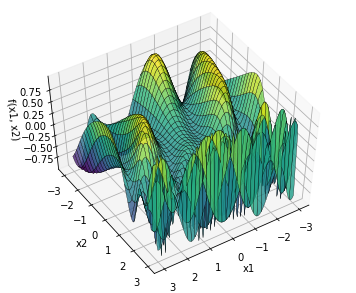

In [17]:
# plot the data
fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection="3d", elev=52.9, azim=57.2)
ax.plot_surface(data["x1"], data["x2"], data["z"], rstride=3, cstride=3, edgecolor='k', linewidth=0.3, alpha=0.8, cmap=plt.cm.viridis)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("f(x1, x2)");

# Get w1-w2-cost landscape

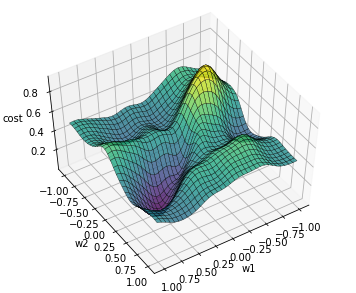

In [22]:
# cost function
def cost_fn(predictions, ground_truths):
    # mean-squared-error
    ground_truths = ground_truths.flatten().astype(np.float32)
    squre = (predictions - ground_truths) ** 2
    return tf.reduce_mean(squre, axis=-1)

# get all possible values to draw cost_landscape
w_grid = np.linspace(w1_w2_range[0], w1_w2_range[1], 100)
grid_w1, grid_w2 = np.meshgrid(w_grid, w_grid)
pred_surface = f_x1x2(data["x1"].reshape([1, -1]),
                      data["x2"].reshape((1, -1)),
                      grid_w1.reshape([-1, 1]),
                      grid_w2.reshape([-1, 1]))
pred_surface = tf.reshape(pred_surface, [100, 100, -1])
cost_landscape = cost_fn(pred_surface, data["z"])

# plot the data
fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection='3d', elev=52.9, azim=57.2)
ax.plot_surface(grid_w1, grid_w2, cost_landscape.numpy(), rstride=3, cstride=3, edgecolor='k', linewidth=0.3, alpha=0.8, cmap=plt.cm.viridis)
ax.set_xlabel("w1")
ax.set_ylabel("w2")
ax.set_zlabel("cost");

# Gradient descent

In [23]:
# batch gradient descent (whole batch)
w1 = tf.Variable(w1_init, trainable=True, dtype=tf.float32)
w2 = tf.Variable(w2_init, trainable=True, dtype=tf.float32)
optimizer = tf.train.GradientDescentOptimizer(lr)

# record w1 w2 and cost to visualize them later
trajectory = []
for i in range(max_epoch):
    with tf.GradientTape() as tape:
        w1w2 = np.array([w1.numpy(), w2.numpy()]).reshape(-1, 1)
        pred = tf.reshape(f_x1x2(data["x1"], data["x2"], w1, w2), [-1])
        cost = cost_fn(pred, data["z"])
        trajectory.append([w1.numpy(), w2.numpy(), cost.numpy()])
        grads = tape.gradient(cost, [w1, w2])
        optimizer.apply_gradients(zip(grads, [w1, w2]))

# Animated gradient descent

In [24]:
# plot the data
line, = ax.plot([], [], [], 'r', lw=2)
point, = ax.plot([], [], [], 'ro')
line.set_data([], [])
line.set_3d_properties([])
point.set_data([], [])
point.set_3d_properties([])


def animate(i):
    ax.title.set_text("iter:%02d, w1: %.2f, w2: %.2f, cost: %.2f" % (i, trajectory[0, i], trajectory[1, i], trajectory[2, i]))
    line.set_data(trajectory[0, :i], trajectory[1, :i])
    line.set_3d_properties(trajectory[2, :i])
    point.set_data(trajectory[0, i - 1:i], trajectory[1, i - 1:i])
    point.set_3d_properties(trajectory[2, i - 1:i])
    return line, point


trajectory = np.array(trajectory).T
anim = animation.FuncAnimation(fig, animate, frames=trajectory.shape[1], interval=120,
                               repeat_delay=0, blit=True)
HTML(anim.to_html5_video())